**Move this file to the project root directory (same as `README.md`) in order to run it.**

# Creating New Cross Sections

In this software, cross-sections are represented as a pair of functions in a tuple.
- first function maps the energy of the neutral particle (photon, neutron, or similar), to the interaction's cross section density (aka absorbance; in units of ${m}^{-1}$).
- second function maps an integer `n_rays` and the energy of the neutral particle and produces an `AngleEnergy` representing `n_rays` random charged products (electron, proton, or similar), distributed according to the differential cross section.

(`AngleEnergy` is a tuple of two same-length arrays representing the angles (in radians) and energies (in joules) of each of the particles.)

Here is the declaration for the `CrossSection` type:

In [1]:
import typing as ty
from acceptance import AngleEnergy

# (phot_energy/J) -> cross_section_density/(/m)
CrossSectionFnTotal = ty.Callable[[float], float]

# (n_rays:int, phot_energy/J) -> electrons:AngleEnergy
CrossSectionFnGenrays = ty.Callable[[int, float], AngleEnergy]

CrossSection = tuple[CrossSectionFnTotal, CrossSectionFnGenrays]

Consider a very simple example differential cross section:

$d\sigma = \beta K_\text{neut} d\Omega_{\theta} / 4 \pi$

Where:
- $K_\text{in}$ is the kinetic energy of the incoming neutral particle
- $\theta$ is the angle between the momentum of the incoming neutral particle before the scattering event and the momentum of the outgoing charged particle after
- $\beta$ is some constant with units of area over energy
- $K_\text{out} = K_\text{in}$ is the kinetic energy of the outgoing particle

This represents a process that gets a linearly larger cross section with the energy of the incoming particle, causing a charged product to be emitted in a random direction.

It could be implemented as follows:

In [2]:
import numpy as np
from physical_constants import barn, MeV, mol, centimeter
from acceptance import AngleEnergy, CrossSection

random = np.random.default_rng()


def gen_example_xsec(
    atom_number_density: float,  # [ / m^3 ]
    beta: float,  # [ m^2 / J ]
) -> CrossSection:
    """
    A function which returns the cross section representation
    for our example cross section.
    """

    def example_xsec_total(in_energy: float) -> float:
        # cross section per atom, increasing linearly with energy
        per_atom_cross_section = in_energy * beta
        return per_atom_cross_section * atom_number_density

    def example_xsec_gen_rays(n_rays: int, in_energy: float) -> AngleEnergy:
        # constant energy
        out_energy = np.ones((n_rays,)) * in_energy
        # uniform sampling of sphere latitude
        out_angle = np.acos(random.uniform(-1, 1, (n_rays,)))
        return out_angle, out_energy

    return example_xsec_total, example_xsec_gen_rays


example_xsec_a: CrossSection = gen_example_xsec(
    atom_number_density=0.01 * mol / centimeter**3,
    beta=1 * barn / MeV,
)

**Useful Note: How to programmatically sample a distribution of known shape**

For a distribution with probability density function $f(x)$, one can sample the corresponding random variable $x(t) \in [x_\text{min},x_\text{max}]$ by this formula (for uniform random variable $t \in [0,1]$):

$$
x(t) = g^{-1}(t)
\space \text { for } \space
g(x) = \frac{\int_{x_\text{min}}^{x} dx' f(x')}{\int_{x_\text{min}}^{x_\text{max}} dx' f(x')}
$$

(ie. the inverse of [[the indefinite integral over all valid values of the probability density function] scaled to be normalized to the range $[0,1]$])

Let's call $g^{-1} (t)$ the sampling function.

In order to set up more realisitc cross sections, however, we need to be able to sample any arbitrary distribution, even if an analytical forms for the sampling function do not exist. Luckily, there is a collection of functions for this in `util.py`. They accept a table of probability density and randomly sample by lineraly interpolating the distribution and numerically applying the above formula, extended both to allow more than one random output variable, and to allow an input argument to interpolate between distributions with. These functions are called `prep_distr_<N>_<M>` and `sample_distr_<N>_<M>` (replace `<N>` and `<M>` with the number of inputs and randomly sampled outputs respectively), seen below:

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


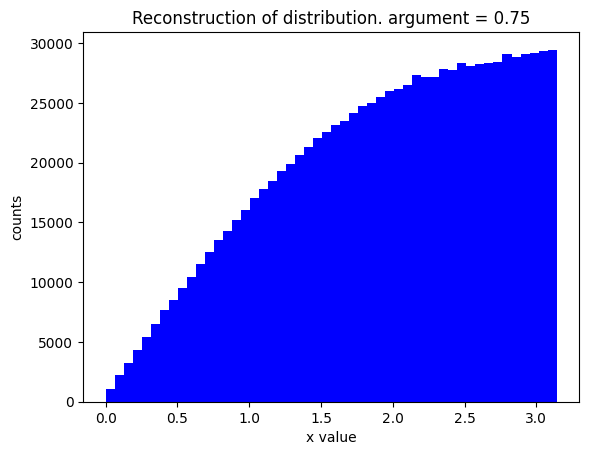

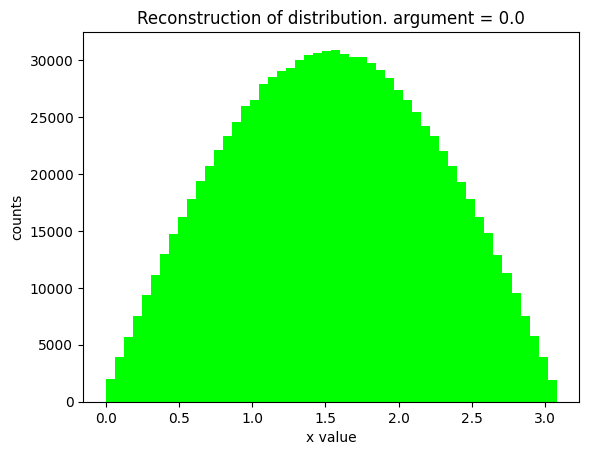

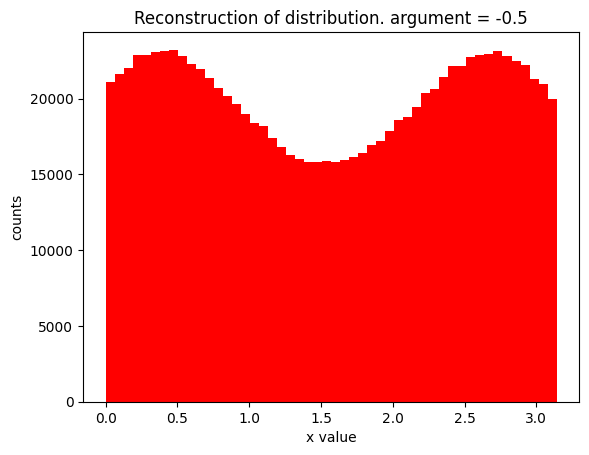

In [3]:
import matplotlib.pyplot as plt
from util import prep_distr_1_1, sample_distr_1_1

arg_range = [-1, 0, 1]
x0_range = np.linspace(0, np.pi)
distr_raw = np.array([
    np.cos(x0_range)**2,
    np.sin(x0_range),
    x0_range,
])

distr = prep_distr_1_1(distr_raw, arg_range, x0_range)

n_samples = 1000_000
for arg, color in [(0.75,"b"),(0.0,"lime"),(-0.5,"r")]: 
    plt.hist(sample_distr_1_1(n_samples, distr, argument=arg), bins=50, color=color)
    plt.xlabel("x value")
    plt.ylabel("counts")
    plt.title(f"Reconstruction of distribution. argument = {arg}")
    plt.show()

The same example cross section as above can be rewritten using this numeric sampling:

In [4]:
import numpy as np
from physical_constants import barn, MeV, mol, centimeter
from acceptance import AngleEnergy, CrossSection
from util import prep_distr_1_1, sample_distr_1_1, dsolid_dangle, d_

random = np.random.default_rng()


def gen_example_xsec(
    atom_number_density: float,  # [ / m^3 ]
    beta: float,  # [ m^2 / J ]
) -> CrossSection:
    """
    A function which returns the cross section representation
    for our example cross section.
    """

    _in_energy = np.linspace(1, 10, 10) * MeV
    _out_angle = np.linspace(0, np.pi, 1000)
    d_out_angle = d_(_out_angle)

    # homogenize dimensionality
    v_in_energy = np.expand_dims(_in_energy, axis=1).repeat(_out_angle.size, axis=1)
    v_out_angle = np.expand_dims(_out_angle, axis=0).repeat(_in_energy.size, axis=0)

    distr_raw = beta * v_in_energy * (d_out_angle * dsolid_dangle(v_out_angle)) # = \beta K d\Omega
    # distr_raw = dsolid_dangle(v_out_angle)   # <- this is equivalent, since any scale will be normalized out
    distr = prep_distr_1_1(distr_raw, _in_energy, _out_angle)

    def example_xsec_total(in_energy: float) -> float:
        # cross section per atom, increasing linearly with energy
        per_atom_cross_section = in_energy * beta
        return per_atom_cross_section * atom_number_density

    def example_xsec_gen_rays(n_rays: int, in_energy: float) -> AngleEnergy:
        # constant energy
        out_energy = np.ones((n_rays,)) * in_energy
        # uniform sampling of sphere latitude, now using sample_distr
        out_angle = sample_distr_1_1(n_rays, distr, in_energy)
        return out_angle, out_energy

    return example_xsec_total, example_xsec_gen_rays


example_xsec_a: CrossSection = gen_example_xsec(
    atom_number_density=0.01 * mol / centimeter**3,
    beta=1 * barn / MeV,
)